# Siamese Networks for Authorship Verification

Siamese Networks were first used decades ago for Signature Verification, and with the new interest in neural networks and deep learning, they are more recently being used for all kinds of verification tasks. Instead of teaching the network to recognise examples of a specific class by giving it lots of labeled examples of that specific class, you instead have it learn a distance function between pairs of examples. It learns to tell if two examples are from the same class or from different classes.

For example, image re-identification is used for automatic access control. A single photo of a Alice as a reference or ID photo. When Alice wants to access the building, a new photo is taken at the door and compared to her reference photo. The door opens if the algorithm detects a match. With a simple classification neural net, we'd need to show the net many examples of Alice, in different poses, wearing different clothing, with her face at different angles. A siamese network can detect Alice even if has never seen her before. Instead of learning what Alice looks like, it learns to tell whether to photos are of the same person by learning a distance function between pairs of photos.

We show here how a Siamese Network can be used for authorship verification -- given two texts, it predicts whether or not they are written by the same author, even if has never seen other texts by that author.

Most of the code for the Siamese Network comes from here: https://github.com/fchollet/keras/blob/master/examples/mnist_siamese_graph.py

In [121]:
import os
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

from collections import Counter
from sklearn.metrics import classification_report

In [198]:
# paths to PAN datasets, available from http://pan.webis.de/clef15/pan15-web/author-identification.html
# and http://pan.webis.de/clef14/pan14-web/author-identification.html
pan15train = "/data/pan15-authorship-verification-training-dataset-english-2015-04-19/"
pan15test = "/data/pan15-authorship-verification-test-dataset2-english-2015-04-19/"
pan14train = "/data/pan14-author-verification-training-corpus-english-novels-2014-04-22/"
pan14test = "/data/pan14-author-verification-test-corpus2-english-novels-2014-04-22/"
pan14train_e = "/data/pan14-author-verification-training-corpus-english-essays-2014-04-22/"
pan14test_e = "/data/pan14-author-verification-test-corpus2-english-essays-2014-04-22/"

In [184]:
def read_file(filepath):
    with open(filepath) as f:
        s = f.read()
    return s

def load_pan_data(directory, prefix="E"):
    """Load known and unknown texts in the PAN data format"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory) if x.startswith(prefix)])
    known_texts = []
    unknown_texts = []
    for author in authors:
        kf = os.path.join(directory, author, "known01.txt")
        uf = os.path.join(directory, author, "unknown.txt")
        known_texts.append(read_file(kf))
        unknown_texts.append(read_file(uf))
        
    truthfile = os.path.join(directory, "truth.txt")
    with open(truthfile) as f:
        lines = f.read().strip().split("\n")
    y = [1 if line.split()[1] == "Y" else 0 for line in lines]
    y = np.array(y)
    return known_texts, unknown_texts, y

def create_pairs(knownX, unknownX):
    """Creates pairs of known and unknown texts"""
    pairs = []
    for i in range(len(knownX)):
        pairs.append([knownX[i], unknownX[i]])
    pairs = np.array(pairs)
    return pairs

##  Vectorization
We represent the text using Tfidf vectors of word- and character n-grams.

Setting `min_df` quite high seems to work well in practice. Previous work has shown that it is the use of common words, especially function words, that differentiates authors, rather than uncommon words, so this makes sense. It also is good for practical reasons -- we need to convert the Sparse Tfidf vectors to dense vectors to feed into Keras, so we can't use too many features

In [185]:
# Vectorizing
def get_fit_vectorizer(texts):
    """Fit a Tfidf vectorizer on character and word n-grams"""
    char_tf = TfidfVectorizer(analyzer='char', ngram_range=(2,4), min_df=0.3)
    word_tf = TfidfVectorizer(ngram_range=(1,2), min_df=0.05)
    vec = FeatureUnion([
        ('char', char_tf),
        ('word', word_tf)
    ])
    vec.fit(texts)
    return vec

def vectorize_and_pair(knowntexts, unknowntexts, vectorizer):
    """Vectorize texts with a pre-fitted vectorizer"""
    known_X = vectorizer.transform(knowntexts).todense()  # dense arrays are inefficient but easier to work with
    unknown_X = vectorizer.transform(unknowntexts).todense()
    pairs = create_pairs(known_X, unknown_X)
    pairs = pairs.squeeze()  # TODO: why do we pick up an extra dimension?
    return pairs

In [199]:
# - read data
p15train_known, p15train_unknown, p15train_labels = load_pan_data(pan15train)
p15test_known, p15test_unknown, p15test_labels = load_pan_data(pan15test)

# - or uncomment to run on novels from 2014 -- still do OK, but not great
# p15train_known, p15train_unknown, p15train_labels = load_pan_data(pan14train)
# p15test_known, p15test_unknown, p15test_labels = load_pan_data(pan14test)

# - or on essays from '14 -- worse than guessing performance
# p15train_known, p15train_unknown, p15train_labels = load_pan_data(pan14train_e)
# p15test_known, p15test_unknown, p15test_labels = load_pan_data(pan14test_e)

# - fit the vectorizer on the training data (known and unknown texts)
vectorizer = get_fit_vectorizer(p15train_known + p15train_unknown)

# - tranform the texts into pairs of vectors
train_pairs = vectorize_and_pair(p15train_known, p15train_unknown, vectorizer)
test_pairs = vectorize_and_pair(p15test_known, p15test_unknown, vectorizer)

In [200]:
# We should be left with (num_samples, 2, num_features) as a shape
train_pairs.shape

(100, 2, 3124)

In [201]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    # The number and size of layers is not that important
    # Dropout has a big (negative?) effect
    seq = Sequential()
    seq.add(Dense(256, input_shape=(input_dim,), activation='relu'))
    seq.add(Dense(256, activation='relu'))      
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    return seq

def compute_accuracy(predictions, labels):
    return np.mean(np.equal(predictions.ravel() < 0.5, labels))

def train(train_pairs, train_labels, epochs=20):
    input_dim = train_pairs.shape[-1]

    # network definition
    base_network = create_base_network(input_dim)

    input_a = Input(shape=(input_dim,))
    input_b = Input(shape=(input_dim,))

    # we re-use the same `base_network` - weights will be shared across the branches
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)
    distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])
    model = Model(inputs=[input_a, input_b], outputs=distance)
    
    # batch size is very sensitive
    rms = RMSprop()
    model.compile(loss=contrastive_loss, optimizer=rms)
    model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels,
              validation_split=0.0,
              batch_size=10,
              epochs=epochs, verbose=0)
    return model

def evaluate(test_pairs, test_y, model, threshold=0.5):
    """Predict and Evaluate for a test set"""
    predicted_distances = model.predict([test_pairs[:, 0], test_pairs[:, 1]])
    predictions = [1 if p[0] <= threshold else 0 for p in predicted_distances]  # close to zero is a small distance and therefore 'same' prediction
    print(Counter(predictions))  # useful for balanced datasets -- we can see if we need to adjust threshold
    print(classification_report(test_y, predictions))
    return predicted_distances


## Training and Testing

We attempt the original task (train on 100 pairs and test on 500) as well as the reverse (train on 500 and test on 100.) Results are a bit variable, but should be 75-80 for test and ~85-90 for train. Delete `verbose=0` above if you want to see the training progress -- training should only take a couple of minutes though.

In [202]:
# The original PAN 15 task -- train on 100 example pairs and test on 500
model = train(train_pairs, p15train_labels, 20)
distances = evaluate(test_pairs, p15test_labels, model)

# The reverse is interesting too, especially as the data is quite different (see distance plots below)
# Train on 500 and test on 100
model2 = train(test_pairs, p15test_labels, 20)
distances2 = evaluate(train_pairs, p15train_labels, model2)

Counter({1: 252, 0: 248})
             precision    recall  f1-score   support

          0       0.78      0.78      0.78       250
          1       0.78      0.78      0.78       250

avg / total       0.78      0.78      0.78       500

Counter({0: 56, 1: 44})
             precision    recall  f1-score   support

          0       0.84      0.94      0.89        50
          1       0.93      0.82      0.87        50

avg / total       0.89      0.88      0.88       100



## Tuning precision and recall
Because we learned a distance function, the further the two pairs are from each other, the more confident we are that they're a different author. Therefore, we can use a low threshold for a high precision on same-author (we only predict that two texts are by the same author if the predicted distance is very small) or a high threshold for a high precision on different-author. Below we should get ~0.95 precision on 1 (same author) and then ~0.96 on 0, while keeping recall reasonable.

In [205]:
_ = evaluate(test_pairs, p15test_labels, model, 0.2)

Counter({0: 377, 1: 123})
             precision    recall  f1-score   support

          0       0.63      0.96      0.76       250
          1       0.91      0.45      0.60       250

avg / total       0.77      0.70      0.68       500



In [206]:
_ = evaluate(test_pairs, p15test_labels, model, 0.8)

Counter({1: 339, 0: 161})
             precision    recall  f1-score   support

          0       0.94      0.60      0.73       250
          1       0.71      0.96      0.81       250

avg / total       0.82      0.78      0.77       500



## Visually comparing our learned distance function to a standard one

We can see that our distance function represents authorship style by comparing it to euclidean distance. Note that in some cases (i.e., the test dataset) a simple distance function provide an above-guessing baseline.

In [207]:
from scipy.spatial.distance import euclidean, cosine
%matplotlib inline
from matplotlib import pyplot as plt

def plot_texts_by_distance(pairs, labels):
    dists = [euclidean(pairs[i][0], pairs[i][1]) for i in range(len(pairs))]
    same = [x for i, x in enumerate(dists) if labels[i]]
    diff = [x for i, x in enumerate(dists) if not labels[i]]
    plt.scatter(range(len(same)), same)
    plt.scatter(range(len(same)), diff)

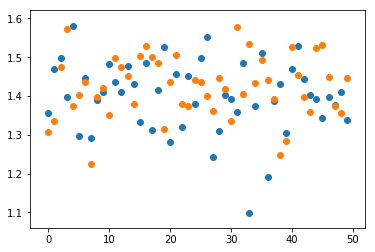

In [208]:
# The training data using euclidean distance
plot_texts_by_distance(train_pairs, p15train_labels)

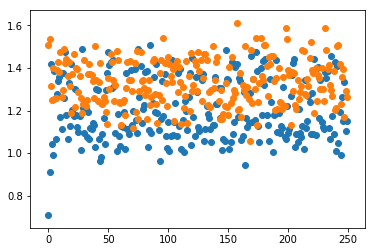

In [209]:
# The test data using euclidean distance
plot_texts_by_distance(test_pairs, p15test_labels)

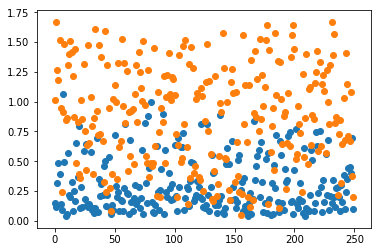

In [210]:
dists = distances
same = [x for i, x in enumerate(dists) if p15test_labels[i]]
diff = [x for i, x in enumerate(dists) if not p15test_labels[i]]
plt.scatter(range(len(same)), same)
plt.scatter(range(len(same)), diff)

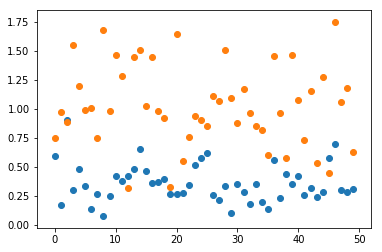

In [211]:
dists = distances2
same = [x for i, x in enumerate(dists) if p15train_labels[i]]
diff = [x for i, x in enumerate(dists) if not p15train_labels[i]]
plt.scatter(range(len(same)), same)
plt.scatter(range(len(same)), diff)